# HW 2: Web Scraping

In this assignment, you will write python programs to scrape data from web pages. As we have seen in class, there are python packages that can help you achieve the goal:

- [`requests`](http://docs.python-requests.org/en/master/api/)
- [`urllib` ](https://docs.python.org/3/library/urllib.html)
- [`BeatifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)

## Submission instruction
- Due by 11:59pm on **Sep. 16th, 2019**
- Complete this notebook and name it as "*CSCI3360\_HW2\_{your first name}.ipynb*".
- Do **not** use any other 3rd party libraries unless you are asked to do so.
- Do **not** _hardcode_ any data.
- Feel free to modify function prototype (i.e., you can add additional input parameters or remove existing ones based on your needs)
- Feel free to define your own functions if needed.

Let's start by importing the required libraries.

In [38]:
!pip install --upgrade --quiet lxml

%matplotlib inline

from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from datetime import timedelta

## August Temperature in Watkinsville, GA

As a warm-up, let's write a python program that extracts daily temperature data for August from a website. Your instructor says that

> "This summer seems to be **much hotter** than usual".

In order to make this claim, we will need to find and analyze some data that supports our claim. 

The _College of Argricultural & Environmental Science_ at UGA maintains a website that reports daily

- min temperature (${}^\circ$F),
- max temperature (${}^\circ$F), and
- precipitation (in).

See the picture below:

<img src="http://cobweb.cs.uga.edu/~jwlee/teaching/csci3360/images/uga_weather.png" />

To visually check this website, open a web browser and enter the following URL (or just click it):

[http://www.georgiaweather.net/index.php?variable=HI&site=WATUGA](http://www.georgiaweather.net/index.php?variable=HI&site=WATUGA).

Carefully look at the url. You can see there's a question mark appended at the end of url for an web page, http://georgiaweather.net/index.php, followed by a set of **key/value pairs** separated by the ampersand ("&") symbol. This is called a <font color='red'>**query string**</font>. A query string is the portion of a URL that contains the data your web browser sends to a web application in the form of HTTP **GET** request. Try selecting a different weather station using the dropdown list in the 'Weather Stations' pane on the left hand side of the page. As soon as you choose a different station, you will see the page is reloaded with a new url where `site` variable contains the abbreviated name of the station you chose. For example, in the above picture, the last key/value pair "site=WATUGA" has been added to select a weather station in Watkinsville, GA, among many stations they have across Georgia.

- The start of query string is indicated with the question mark (?).
- The query string contains a (set of) key/value pair.
- The key/value pair has the form of `{parameter name}={parameter value}`.
- Each key/value pair is separated by an ampersand (&) symbol.

Unlike HTTP [GET](https://en.wikipedia.org/wiki/Hypertext_Transfer_Protocol#Request_methods) method (which uses the url to send information to the server), the [POST](https://en.wikipedia.org/wiki/POST_(HTTP)) method embeds the information inside the HTTP request body.

In this part, we will compare the August temperatures in Watkinsville, GA, for 2019 with those for 2018. For your information, the site allows you to query the temperature data for maximum one year.

### Q1. Write a function that extracts daily min/max temperatures for the given period and station (30 pts).
- Before writing a code, visit this [page](http://www.georgiaweather.net/index.php?variable=HI&site=WATUSDA) and review the lecture slides on how to make GET and POST [requests](https://2.python-requests.org/en/master/user/quickstart/#make-a-request) in python.
- You will see that the information we need can be obtained by setting the From and To dates to Aug. 1, 2018 and Aug. 30, 2019 from the dropdown lists, respectively.
- We will programatically choose the From and To dates by sending using HTTP GET and POST methods.
- To see what type/format of values are accepted, you will need to see the html source code of page.
- To get the historical temperature data for a station, you need to pass two variables, `HI` and `site`, to the server using the URL.
- You will see that the query result is returned in the form of HTML tables.


In [1]:
#Credit: https://srome.github.io/Parsing-HTML-Tables-in-Python-with-BeautifulSoup-and-pandas/

import requests
import pandas as pd
from bs4 import BeautifulSoup

class HTMLTableParser:

    def parse_url(self, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        return [(table['id'],self.parse_html_table(table))\
                for table in soup.find_all('table')]  

    def parse_html_table(self, table):
        n_columns = 0
        n_rows=0
        column_names = []

        # Find number of rows and columns
        # we also find the column titles if we can
        for row in table.find_all('tr'):

            # Determine the number of rows in the table
            td_tags = row.find_all('td')
            if len(td_tags) > 0:
                n_rows+=1
                if n_columns == 0:
                    # Set the number of columns for our table
                    n_columns = len(td_tags)

            # Handle column names if we find them
            th_tags = row.find_all('th') 
            if len(th_tags) > 0 and len(column_names) == 0:
                for th in th_tags:
                    column_names.append(th.get_text())

        # Safeguard on Column Titles
        if len(column_names) > 0 and len(column_names) != n_columns:
            raise Exception("Column titles do not match the number of columns")

        columns = column_names if len(column_names) > 0 else range(0,n_columns)
        df = pd.DataFrame(columns = columns,
                          index= range(0,n_rows))
        row_marker = 0
        for row in table.find_all('tr'):
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                df.iat[row_marker,column_marker] = column.get_text()
                column_marker += 1
            if len(columns) > 0:
                row_marker += 1

        # Convert to float if possible
        for col in df:
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass

        return df

In [83]:
def get_temperature(fromMonth, fromDay, fromYear, toMonth, toDay, toYear, station):
    """
    Parameters
    ------------
    fromMonth: string, month name (e.g., January, February, and so on)
    fromDay: an integer between 1 and 31
    fromYear: an integer between 1996 and 2019
    toMonth: string, month name
    toDay: an intesger between 1 and 31
    toYear: an integer between 1996 and 2019
    station: string, station name
    
    Return
    ------------
    df: DataFrame, each row contains 4 features: Date, MaxTemp, MinTemp, and Rain
        - Date: datetime64
        - MaxTemp: float64
        - MinTemp: float64
        - Rain: float64
    """
    
    #------------------------------------#
    target_url = f"http://www.georgiaweather.net/index.php?variable=HI&site={station}"

    html = requests.post(target_url, data=[
        ('fromMonth', fromMonth),
        ('fromDay', fromDay),
        ('fromYear', fromYear),
        ('toMonth', toMonth),
        ('toDay', toDay),
        ('toYear', toYear)
    ]).text

    soup = BeautifulSoup(html)
    table_parser = HTMLTableParser()

    res = table_parser.parse_html_table(soup.find_all('table')[1]).iloc[6:,:4]
    res.columns = res.iloc[0]
    res = res.drop(6).reset_index(drop=True)
    
    res['Max Temperature[&degF]'] = res['Max Temperature[&degF]'].apply(lambda x: float(x))
    res['Min Temperature[&degF]'] = res['Min Temperature[&degF]'].apply(lambda x: float(x))
    res['Rain (in)'] = res['Rain (in)'].apply(lambda x: float(x))
    
    #------------------------------------#

    return res

#---------------------------------------#
#       test code (do not modify)       #
#---------------------------------------#
"""
Note that your code will be tested with arbitrary From/To dates. Please 
make sure you try other (valid) input parameter values.
For example, get_temperature('December', 1, 2018, 'January', 2, 2019, 'WATUGA') should work 
without any errors.
"""
# This should return a data frame containing all records for WATUGA site within the time window 08/01/2018 - 08/31/2019
mydata = get_temperature('August', 1, 2018, 'August', 31, 2019, 'WATUGA')
print('mydata contains {} rows and {} columns.\n\n'.format(*mydata.shape))
print(mydata.info())

mydata contains 396 rows and 4 columns.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 4 columns):
Date                      396 non-null object
Max Temperature[&degF]    396 non-null float64
Min Temperature[&degF]    396 non-null float64
Rain (in)                 396 non-null float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB
None


In [84]:
mydata.head()

6    Date  Max Temperature[&degF]  Min Temperature[&degF]  Rain (in)
0  Aug 01                    78.9                    69.2       1.33
1  Aug 02                    73.6                    69.9       0.86
2  Aug 03                    85.7                    70.3       0.81
3  Aug 04                    88.6                    69.1       0.00
4  Aug 05                    91.6                    70.7       0.33

### Hint 1: Identify the following lines from the page source code. 

```HTML
<form name = "test" action = "index.php?variable=HI&site=WATUGA" method = "POST">
	<!--Beginning of From Month drop down menu -->
	From: 
			<select name="fromMonth"><option value = January>January</option><option value = February>February</option><option value = March>March</option><option value = April>April</option><option value = May>May</option><option value = June>June</option><option value = July>July</option><option value = August>August</option><option value = September>September</option><option value = October>October</option>
```
The `action` attribute of `form` tag specifies the url of the page to which the form data is submitted. From above, we can see that it is submitted to [http://www.georgiaweather.net/index.php?variable=HI&site=WATUGA](http://www.georgiaweather.net/index.php?variable=HI&site=WATUGA).
To select the date, you need to send the following data to the server using an HTTP **POST** request.
- `fromMonth`
- `fromDay`
- `fromYear`
- `toMonth`
- `toDay`
- `toYear`

Once you pass the above information, the server will return an HTML table showing the daily temperatures for the specified time period. You can parse the table using the `BeautifulSoup` package.

### Hint 2: Datetime in python
Python has a built-in module for handling basic date and time types. The `datetime` package provides various classes and useful functions for handling dates and times. To parse a date string into a `datetime` object, you can use `datetime.datetime.strptime()` function. See [here](https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime) for detailed information. Suppose you would like to convert the string `"2019/09/09"` into a `datetime` object. You can do the following:

In [51]:
my_date_obj = datetime.strptime("2019/09/09", '%Y/%m/%d')
print(my_date_obj, " \tdata type=", type(my_date_obj))

2019-09-09 00:00:00  	data type= <class 'datetime.datetime'>


To understand what arguments you need to pass, see the table in this [page](https://docs.python.org/3.7/library/datetime.html#strftime-strptime-behavior). 

One problem we have is that our 'Date' field doesn't contain year information. For instance, Aug. 01, Aug. 02, and so on. However, we can figure out the year part since we know
- the start date of the query result (recall that we have fromYear, fromMonth, fromDay),
- the result is sorted by the 'Date' field, and
- each row corresponds to a day.

You can create a `datetime` object corresponding to the start date of query result and 1 day to the object whenever you insert a new record. To add dates or times to a `datetime` object, you can use `datetime.timedelta` object. For example,


In [42]:
now = datetime.now()

print("Current datetime: {}", now)
print("Datetime in 5 miniutes: {}".format(now + timedelta(minutes=5)))

Current datetime: {} 2019-09-08 16:04:52.891683
Datetime in 5 miniutes: 2019-09-08 16:09:52.891683


You can find more detailed information and examples from [here](https://docs.python.org/3/library/datetime.html#timedelta-objects). Feel free to suggest and use your own solution if you think there's a better way to handle the missing year information.

### Q2. Using the retrieved data (i.e., mydata variable), write the python codes that answer the following questions.
1. (5 pts) Which date did record the highest temperature? (Hint: see the member functions of `Pandas.Series` [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html).)

In [40]:
mydata.columns

Index(['Date', 'Max Temperature[&degF]', 'Min Temperature[&degF]',
       'Rain (in)'],
      dtype='object', name=6)

In [52]:
#------------------------------#
#   Write your answer here     #
#------------------------------#

mydata.sort_values('Max Temperature[&degF]')

6      Date  Max Temperature[&degF]  Min Temperature[&degF]  Rain (in)
130  Dec 09                    37.0                    33.4       1.38
164  Jan 12                    39.8                    33.7       0.43
203  Feb 20                    40.5                    36.5       0.25
131  Dec 10                    41.8                    36.6       0.25
129  Dec 08                    42.2                    36.8       1.81
..      ...                     ...                     ...        ...
382  Aug 18                    94.5                    69.1       0.02
337  Jul 04                    94.6                    73.0       0.00
300  May 28                    94.6                    68.5       0.00
335  Jul 02                    94.8                    71.3       0.00
377  Aug 13                    97.0                    72.2       0.04

[396 rows x 4 columns]

2. (10 pts) Add a new categorical column *"Intensity"* which defines categories of rainfall according to the precipitation.
    - light: Rain < 0.098
    - moderate: 0.098 <= Rain < 0.3
    - heavy: 0.3 <= Rain < 2.0
    - violent: Rain >= 2.0

In [91]:
#------------------------------#
#   Write your answer here     #
#------------------------------#
bins = [-999,0.098,0.3,2.0,9999]
labels = ['light','moderate','heavy', 'violent']
mydata['Rain Cat'] = pd.cut(mydata['Rain (in)'], bins, labels=labels)

mydata.head()

6    Date  Max Temperature[&degF]  Min Temperature[&degF]  Rain (in) Rain Cat
0  Aug 01                    78.9                    69.2       1.33    heavy
1  Aug 02                    73.6                    69.9       0.86    heavy
2  Aug 03                    85.7                    70.3       0.81    heavy
3  Aug 04                    88.6                    69.1       0.00    light
4  Aug 05                    91.6                    70.7       0.33    heavy

3. (5 pts) For each rainfall category, counts the days. In other words, how many days of 'light'/'moderate'/'heavy'/'violent' rainfall did WATUGA have?

In [92]:
#------------------------------#
#   Write your answer here     #
#------------------------------#
mydata['Rain Cat'].value_counts()




light       303
heavy        55
moderate     35
violent       3
Name: Rain Cat, dtype: int64

4. (10 pts) Can we say on average we have more rain during the summer? Answer this question by reporting monthly average precipitation from Aug., 2018 to Jul., 2019. The answer should be **sorted** in descending order of average precipitation.
    - Hint 1: use a `datetime.datetime` object for filtering
    - Hint 2: to access datetime object in 'Date' series, you can use `Series.dt` (read its documentation [page](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#datetimelike-properties))    
    - Note that there are multiple ways to implment this; the above is just one of them.

In [118]:
import datetime
toYear = 2019
last_date = parse(mydata['Date'].values[-1]).replace(year=toYear)
n_days = len(mydata)
mydata['Date'].apply(lambda x: x.name)


AttributeError: 'str' object has no attribute 'name'

datetime.datetime(1990, 8, 31, 0, 0)

In [94]:
from dateutil.parser import parse


mydata['Date'].apply(lambda x: parse(x))

0     2019-08-01
1     2019-08-02
2     2019-08-03
3     2019-08-04
4     2019-08-05
         ...    
391   2019-08-27
392   2019-08-28
393   2019-08-29
394   2019-08-30
395   2019-08-31
Name: Date, Length: 396, dtype: datetime64[ns]

In [67]:
#------------------------------#
#   Write your answer here     #
#------------------------------#






Date
December     0.329032
June         0.233000
November     0.195333
January      0.194194
October      0.165484
February     0.141786
August       0.135161
April        0.127333
May          0.102258
March        0.080323
July         0.056129
September    0.054000
Name: Rain, dtype: float64

5. (10 pts) For each month in [Aug. 2018 - Jul. 2019], counts the number of rainy days. 
    - A day is considered as a rainy day if 'Intensity' > light.

In [91]:
#------------------------------#
#   Write your answer here     #
#------------------------------#






Date
April         6
August        6
December     11
February     10
January       8
July          7
June          7
March         5
May           4
November     11
October       5
September     4
Name: Intensity, dtype: int64

### Q3. Draw a line plot showing the trend of max August temperatures. It should contain two lines, one for MaxTemp for Aug. 2018 and the other for MaxTemp for Aug. 2019.
1. (10 pts) First, select rows corresponding to Aug. 2018 and Aug. 2019 and store them into two different variables. Then construct a new `DataFrame` object by concatenating series. Your new `DataFrame` needs to contain 3 fields:
    - Day,
    - MaxTemp2018,
    - MaxTemp2019.
For this, you will need to use the following two functions:
    - [`Series.rename()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rename.html) to change the name of a series and
    - [`Pandas.concat()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) to construct a new `DataFrame` by concatenating existing series. Notice that you need to concatenate the series horizontally. Carefully read the documentation to see which parameter you need to change.

In [84]:
import matplotlib.pyplot as plt

# use these variables if needed
aug2018 = datetime(2018, 8, 1)
sep2018 = datetime(2018, 9, 1)
aug2019 = datetime(2019, 8, 1)
sep2019 = datetime(2019, 9, 1)

######################################
#   Your code for the plot goes here #
######################################




               
# test code (do not modify)
print("The new dataframe object contains {} rows and {} columns.\n\n".format(*df.shape))
print(df.info())

The new dataframe object contains 31 rows and 3 columns.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
Day            31 non-null int64
MaxTemp2018    31 non-null float64
MaxTemp2019    31 non-null float64
dtypes: float64(2), int64(1)
memory usage: 824.0 bytes
None


2. (5 pts) Draw a line plot that comparaes August temperateures for 2018 and 2019.

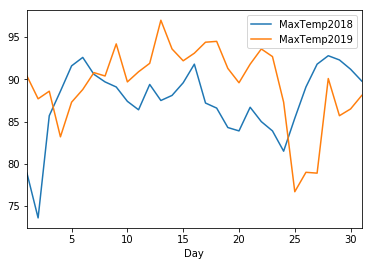

In [85]:
######################################
#   Your code for the plot goes here #
######################################



### Q4. (15 pts) In this question, we will collect the temperature data for 2016, 2017, and 2018, and then aggregate them to compute the mean and standard deviation of monthly temperature. 
- The temperature for a day is given by taking the average of min and max temperatures for that day, i.e., $\text{Temp} = \frac{\text{MinTemp} + \text{MaxTemp}}{2}$.
- To collect the data for 3 years, use the `get_temperature()` function you implemented in Q1.
- To concatenate them into a single DataFrame, use `pandas.concat()` function.
- Fix `site=WATUGA`

In [101]:
#------------------------------#
#   Write your answer here     #
#------------------------------#
dfs = []

for fromYear in [2016, 2017, 2018]:
    dfs.append(get_temperature('January', 1, fromYear, 'December', 31, fromYear, 'WATUGA'))

# 1. merge 3 DataFrames into one


# 2. aggregate by month name and compute the mean and stdev.



# 3. form a DataFrame by concatenating the mean and stdev.
print(ret)

            MeanTemp  StdevTemp
Date                           
April      61.991111   7.254656
August     78.833333   2.960100
December   46.340860   7.591117
February   52.690000   9.028156
January    44.327419  10.463538
July       80.110753   2.285503
June       77.612778   3.485303
March      55.381720   9.446591
May        70.625806   5.652311
November   53.137222   8.034541
October    65.422581   8.391674
September  76.033889   4.853811
